In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from pybaseball import batting_stats
from pybaseball import team_batting, statcast
from pybaseball import statcast_batter
from pybaseball import team_game_logs
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.width = 0
pd.options.display.max_colwidth = 100
import warnings
warnings.filterwarnings(action='ignore')

In [96]:
df = statcast('2024-01-01', '2024-07-31')

This is a large query, it may take a moment to complete
Skipping offseason dates


100%|██████████| 139/139 [03:53<00:00,  1.68s/it]


In [113]:
df2 = statcast('2024-08-01', '2024-12-31')
df = pd.concat([df, df, df2])

This is a large query, it may take a moment to complete
Skipping offseason dates


100%|██████████| 107/107 [02:00<00:00,  1.13s/it]


In [129]:
df['bahb'] = df['babip_value']
df.loc[df['events'] == 'home_run', 'bahb'] = 1
df.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,fielder_2,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,estimated_slg_using_speedangle,delta_pitcher_run_exp,hyper_speed,home_score_diff,bat_score_diff,home_win_exp,bat_win_exp,age_pit_legacy,age_bat_legacy,age_pit,age_bat,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches,bahb
3258,SI,2024-07-31,90.6,-3.65,3.68,"Thompson, Ryan",656180,657044,field_out,hit_into_play,<NA>,<NA>,<NA>,<NA>,7,"Riley Adams grounds out, second baseman Ketel Marte to first baseman Pavin Smith.",R,R,R,AZ,WSH,X,4,ground_ball,1,0,2024,-1.04,-0.83,-0.43,2.01,683083,695578,671277,2,9,Top,149.46,154.67,<NA>,<NA>,<NA>,<NA>,10.330246,-131.421557,3.662185,-14.282736,29.777708,-42.86527,3.4,1.63,2,104.2,-42,91.0,2001,6.9,747170,645444,656976,606466,553993,672695,664983,677950,682998,53.63,0.091,0.075,0.0,1,0,0,2,78,2,Sinker,5,4,4,5,4,5,4,5,Strategic,Standard,271,0.231,-0.309,78.1,6.5,0.108,0.309,104.2,1,-1,0.769,0.231,32,28,32,28,1,2,3,1,2,7,3.64,1.04,1.04,-8.5,-24.126498,27.732897,43.524299,34.924618,7.94146,0
3398,SI,2024-07-31,90.2,-3.71,3.61,"Thompson, Ryan",656180,657044,NaN,ball,<NA>,<NA>,<NA>,<NA>,13,"Riley Adams grounds out, second baseman Ketel Marte to first baseman Pavin Smith.",R,R,R,AZ,WSH,B,<NA>,NaN,0,0,2024,-1.15,-0.57,-1.28,1.72,683083,695578,671277,2,9,Top,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,8.568248,-130.962824,2.588053,-15.099617,30.165099,-39.586009,3.33,1.63,<NA>,<NA>,<NA>,90.6,1925,6.8,747170,645444,656976,606466,553993,672695,664983,677950,682998,53.65,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,78,1,Sinker,5,4,4,5,4,5,4,5,Standard,Standard,274,0.0,0.031,<NA>,<NA>,<NA>,-0.031,<NA>,1,-1,0.769,0.231,32,28,32,28,1,2,3,1,2,7,3.41,1.15,1.15,-8.3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3513,SI,2024-07-31,91.7,-3.76,3.68,"Thompson, Ryan",671277,657044,NaN,ball,<NA>,<NA>,<NA>,<NA>,14,Ryan Thompson intentionally walks Luis García Jr.,R,L,R,AZ,WSH,B,<NA>,NaN,1,0,2024,-1.31,-0.44,1.12,1.39,682928,683083,695578,2,9,Top,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,15.300451,-132.615713,1.158451,-18.778589,29.433604,-37.949619,3.51,1.73,<NA>,<NA>,<NA>,92.3,2232,7.1,747170,645444,656976,606466,553993,672695,664983,677950,682998,53.44,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,77,2,Sinker,5,3,3,5,4,5,4,5,Standard,Standard,268,-0.056,0.088,<NA>,<NA>,<NA>,-0.088,<NA>,2,-2,0.859,0.141,32,24,32,24,1,4,3,1,2,2,3.2,1.31,-1.31,-10.2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3629,SI,2024-07-31,91.7,-3.59,3.7,"Thompson, Ryan",671277,657044,NaN,ball,<NA>,<NA>,<NA>,<NA>,14,Ryan Thompson intentionally walks Luis García Jr.,R,L,R,AZ,WSH,B,<NA>,NaN,0,0,2024,-1.19,-0.4,1.71,1.61,682928,683083,695578,2,9,Top,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,16.113686,-132.591874,1.556585,-17.504657,28.33536,-37.563952,3.58,1.8,<NA>,<NA>,<NA>,92.4,2176,7.0,747170,645444,656976

In [130]:
col_df = df[(df.home_team == 'COL') & (df['description'] == 'hit_into_play') & (df['estimated_woba_using_speedangle'] != '<NA>')]
#col_df.head()
print(col_df['estimated_woba_using_speedangle'].mean())
print(col_df['woba_value'].mean())

0.36945062240663895
0.4128284923928077


In [131]:
in_play_df = df[(df['home_team'] != 'COL') & (df['description'] == 'hit_into_play') & (df['estimated_woba_using_speedangle'] != '<NA>')]
print(in_play_df['estimated_woba_using_speedangle'].mean())
print(in_play_df['woba_value'].mean())

0.36635235934078486
0.37312516448103444


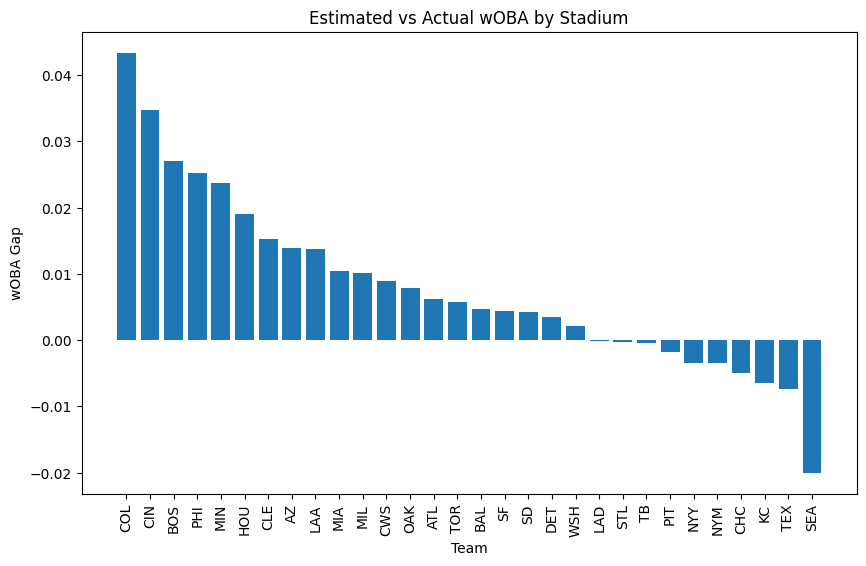

In [132]:
total_in_play_df = df[(df['description'] == 'hit_into_play') & (df['estimated_woba_using_speedangle'] != '<NA>')]
total_in_play_df['wOBA Gap'] = total_in_play_df['woba_value'] - total_in_play_df['estimated_woba_using_speedangle']
team_gaps = total_in_play_df.groupby('home_team')['wOBA Gap'].mean()
team_gaps = team_gaps.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(team_gaps.index, team_gaps.values)
plt.title('Estimated vs Actual wOBA by Stadium')
plt.xlabel('Team')
plt.ylabel('wOBA Gap')
plt.xticks(rotation=90)
plt.show()

- Histogram
- Launch speed (x) vs. distance (y)
- Separate based off Rockies at home

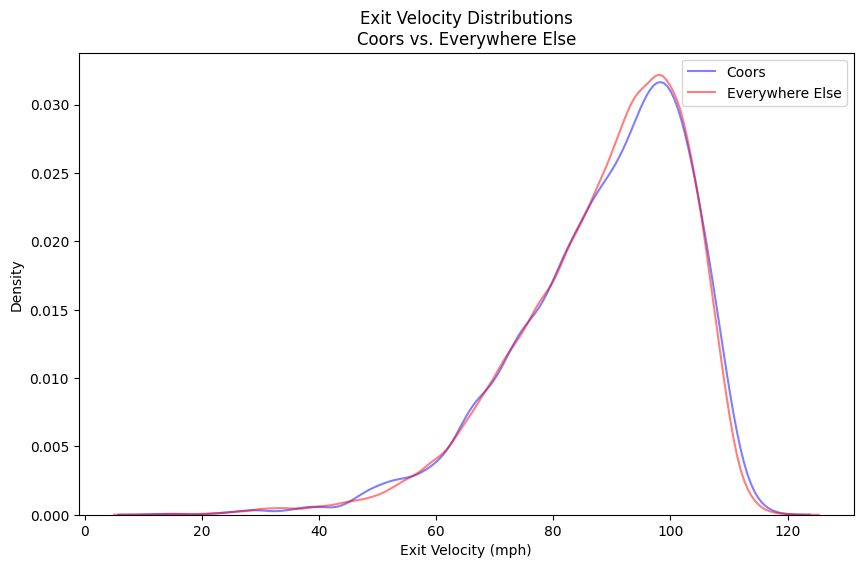

In [133]:
plt.figure(figsize=(10, 6))
sns.kdeplot(col_df['launch_speed'], color='blue', label='Coors', alpha=0.5)
sns.kdeplot(in_play_df['launch_speed'], color='red', label='Everywhere Else', alpha=0.5)
plt.title('Exit Velocity Distributions\nCoors vs. Everywhere Else')
plt.xlabel('Exit Velocity (mph)')
plt.legend()
plt.show()

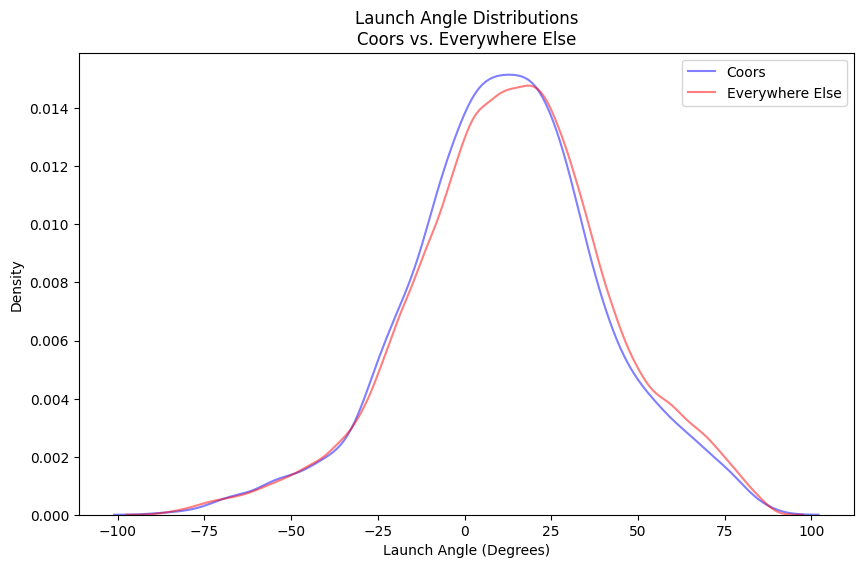

In [134]:
plt.figure(figsize=(10, 6))
sns.kdeplot(col_df['launch_angle'], color='blue', label='Coors', alpha=0.5)
sns.kdeplot(in_play_df['launch_angle'], color='red', label='Everywhere Else', alpha=0.5)
plt.title('Launch Angle Distributions\nCoors vs. Everywhere Else')
plt.xlabel('Launch Angle (Degrees)')
plt.legend()
plt.show()

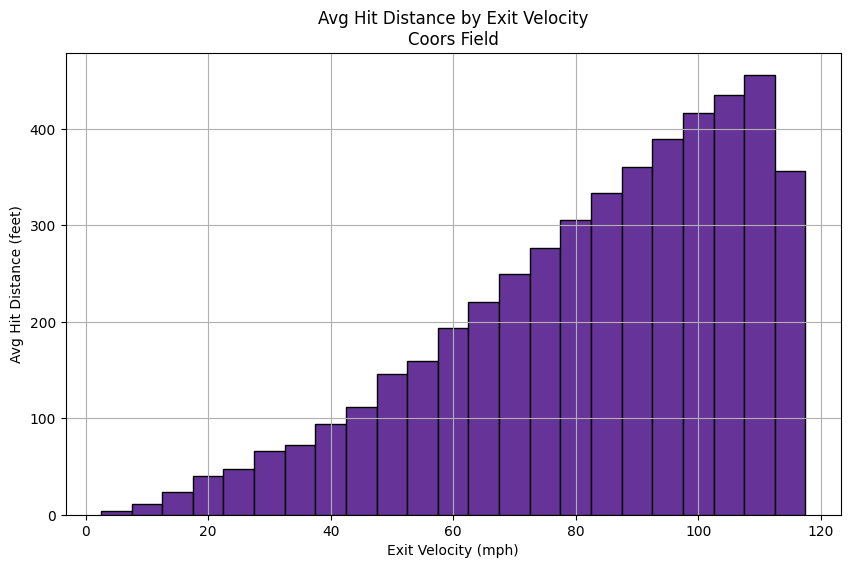

In [ ]:
step = 5
col_df['ev_bucket'] = np.floor(col_df['launch_speed'] / step) * step
dist = col_df.groupby('ev_bucket').agg(percentile_90 = ('hit_distance_sc',lambda x: x.quantile(0.9)))
#dist = dist.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(dist['percentile_90'].index, dist['percentile_90'].values, width=step, color='rebeccapurple', edgecolor='black')
plt.title('Avg Hit Distance by Exit Velocity\nCoors Field')
plt.xlabel('Exit Velocity (mph)')
plt.ylabel('Avg Hit Distance (feet)')
plt.grid(which='major')
plt.show()

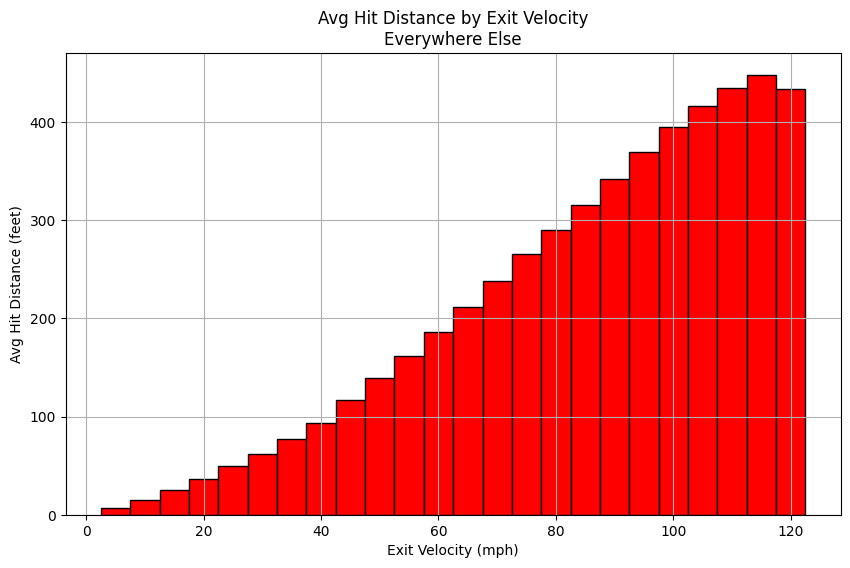

In [71]:
step = 5
in_play_df['ev_bucket'] = np.floor(in_play_df['launch_speed'] / step) * step
dist = in_play_df.groupby('ev_bucket').agg(percentile_90 = ('hit_distance_sc',lambda x: x.quantile(0.9)))
#dist = dist.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(dist['percentile_90'].index, dist['percentile_90'].values, width=step, color='red', edgecolor='black')
plt.title('Avg Hit Distance by Exit Velocity\nEverywhere Else')
plt.xlabel('Exit Velocity (mph)')
plt.ylabel('Avg Hit Distance (feet)')
plt.grid(which='major')
plt.show()

In [120]:
step = 5
#min_la = 15
#max_la = 75
#min_ev = 75
#max_ev = 110
min_count = 10

col_df['ev_bucket'] = np.floor(col_df['launch_speed'] / step) * step
col_df['la_bucket'] = np.floor(col_df['launch_angle'] / step) * step
col_dist_full = col_df.groupby(['ev_bucket', 'la_bucket']).agg(
    avg_dist_col=('hit_distance_sc', 'mean'),
    count_col=('hit_distance_sc', 'count')
).reset_index()
#col_dist = col_dist_full[(col_dist_full.la_bucket >= min_la) & (col_dist_full.la_bucket <= max_la) & (col_dist_full.ev_bucket >= min_ev) & (col_dist_full.ev_bucket <= max_ev)]

in_play_df['ev_bucket'] = np.floor(in_play_df['launch_speed'] / step) * step
in_play_df['la_bucket'] = np.floor(in_play_df['launch_angle'] / step) * step
in_play_dist_full = in_play_df.groupby(['ev_bucket', 'la_bucket']).agg(
    avg_dist_tot=('hit_distance_sc', 'mean'),
    count_tot=('hit_distance_sc', 'count')
).reset_index()
#in_play_dist = in_play_dist_full[(in_play_dist_full.la_bucket >= min_la) & (in_play_dist_full.la_bucket <= max_la) & (in_play_dist_full.ev_bucket >= min_ev) & (in_play_dist_full.ev_bucket <= max_ev)]

dist = pd.merge(col_dist_full, in_play_dist_full, on=['ev_bucket', 'la_bucket'], how='inner')
dist['distance_gap'] = dist['avg_dist_col'] - dist['avg_dist_tot']
dist['ev_bucket'] = dist['ev_bucket'].astype(int)
dist['la_bucket'] = dist['la_bucket'].astype(int)

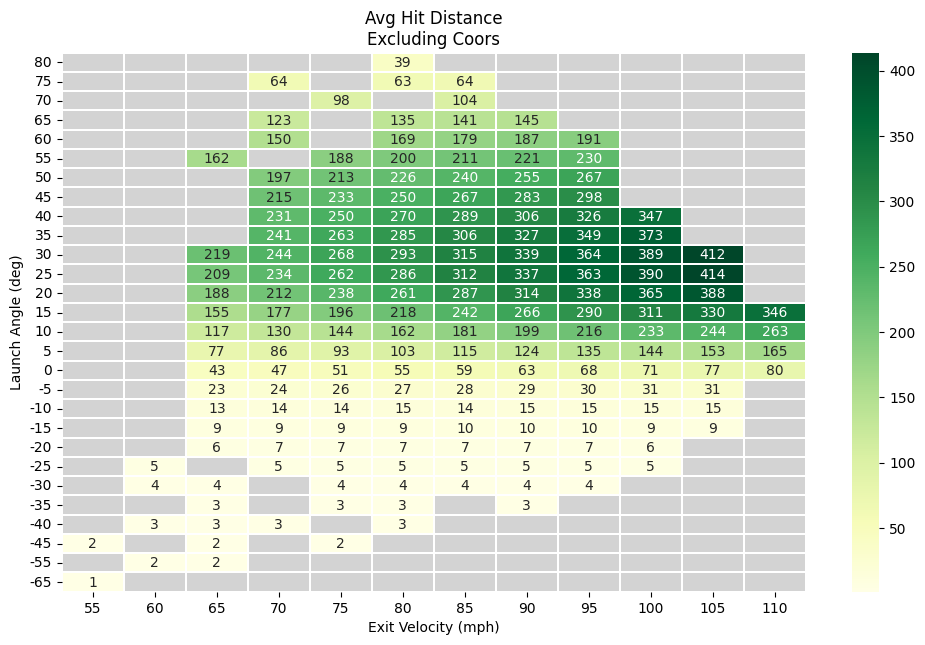

In [121]:
dist_pivot = dist[dist['count_col'] >= min_count].pivot(index='la_bucket', columns='ev_bucket', values='avg_dist_tot')
#dist_pivot[pd.isna(dist_pivot)] = 0.0
dist_pivot = dist_pivot.astype(float)


#limit = max(list(dist_pivot.max()) + list(dist_pivot.min()), key=abs)
#divnorm = colors.TwoSlopeNorm(vmin = -1 * limit, vcenter = 0, vmax = limit)

fig, ax = plt.subplots(figsize = (12, 7))
ax = sns.heatmap(dist_pivot, cmap = 'YlGn', linewidths = 0.01, annot = True, fmt = ".0f")
ax.set_facecolor('lightgray')
ax.invert_yaxis()
ax.set_title('Avg Hit Distance\nExcluding Coors')
ax.set_ylabel('Launch Angle (deg)')
ax.set_xlabel('Exit Velocity (mph)')
plt.show()

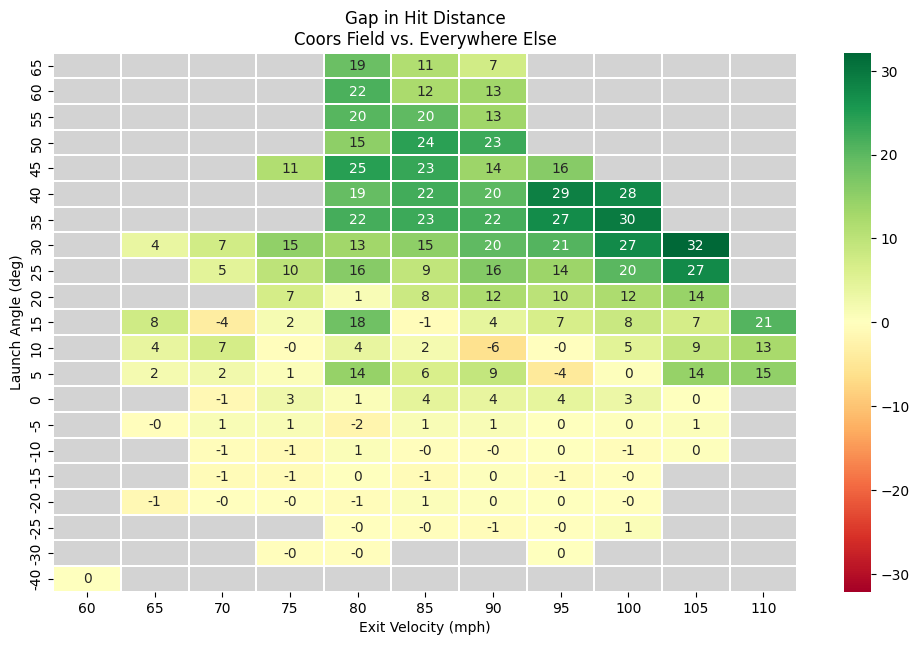

In [159]:
gap_pivot = dist[dist['count_col'] >= min_count].pivot(index='la_bucket', columns='ev_bucket', values='distance_gap')
#gap_pivot[pd.isna(gap_pivot)] = 0.0
gap_pivot = gap_pivot.astype(float)

limit = max(list(gap_pivot.max()) + list(gap_pivot.min()), key=abs)
divnorm = colors.TwoSlopeNorm(vmin = -1 * limit, vcenter = 0, vmax = limit)

fig, ax = plt.subplots(figsize = (12, 7))
ax = sns.heatmap(gap_pivot, cmap = 'RdYlGn', norm=divnorm, linewidths = 0.01, annot = True, fmt = ".0f")
ax.set_facecolor('lightgray')
ax.invert_yaxis()
ax.set_title('Gap in Hit Distance\nCoors Field vs. Everywhere Else')
ax.set_ylabel('Launch Angle (deg)')
ax.set_xlabel('Exit Velocity (mph)')
plt.show()

In [135]:
step = 5
#min_la = 15
#max_la = 75
#min_ev = 75
#max_ev = 110
min_count = 10

col_df['ev_bucket'] = np.floor(col_df['launch_speed'] / step) * step
col_df['la_bucket'] = np.floor(col_df['launch_angle'] / step) * step
col_babip_full = col_df.groupby(['ev_bucket', 'la_bucket']).agg(
    avg_babip_col=('babip_value', 'mean'),
    count_col=('babip_value', 'count')
).reset_index()
#col_dist = col_dist_full[(col_dist_full.la_bucket >= min_la) & (col_dist_full.la_bucket <= max_la) & (col_dist_full.ev_bucket >= min_ev) & (col_dist_full.ev_bucket <= max_ev)]

in_play_df['ev_bucket'] = np.floor(in_play_df['launch_speed'] / step) * step
in_play_df['la_bucket'] = np.floor(in_play_df['launch_angle'] / step) * step
in_play_babip_full = in_play_df.groupby(['ev_bucket', 'la_bucket']).agg(
    avg_babip_tot=('babip_value', 'mean'),
    count_tot=('babip_value', 'count')
).reset_index()
#in_play_dist = in_play_dist_full[(in_play_dist_full.la_bucket >= min_la) & (in_play_dist_full.la_bucket <= max_la) & (in_play_dist_full.ev_bucket >= min_ev) & (in_play_dist_full.ev_bucket <= max_ev)]

babip = pd.merge(col_babip_full, in_play_babip_full, on=['ev_bucket', 'la_bucket'], how='inner')
babip['babip_gap'] = babip['avg_babip_col'] - babip['avg_babip_tot']
babip['ev_bucket'] = babip['ev_bucket'].astype(int)
babip['la_bucket'] = babip['la_bucket'].astype(int)

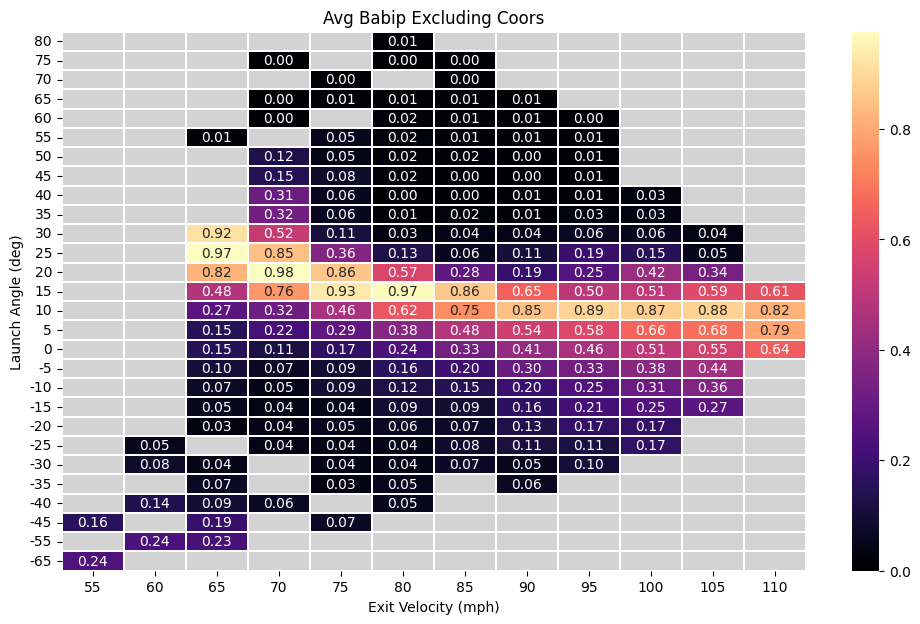

In [136]:
babip_pivot = babip[babip['count_col'] >= min_count].pivot(index='la_bucket', columns='ev_bucket', values='avg_babip_tot')
#dist_pivot[pd.isna(dist_pivot)] = 0.0
babip_pivot = babip_pivot.astype(float)


#limit = max(list(dist_pivot.max()) + list(dist_pivot.min()), key=abs)
#divnorm = colors.TwoSlopeNorm(vmin = -1 * limit, vcenter = 0, vmax = limit)

fig, ax = plt.subplots(figsize = (12, 7))
ax = sns.heatmap(babip_pivot, cmap = 'magma', linewidths = 0.01, annot = True, fmt = ".2f")
ax.set_facecolor('lightgray')
ax.invert_yaxis()
ax.set_title('Avg Babip Excluding Coors')
ax.set_ylabel('Launch Angle (deg)')
ax.set_xlabel('Exit Velocity (mph)')
plt.show()

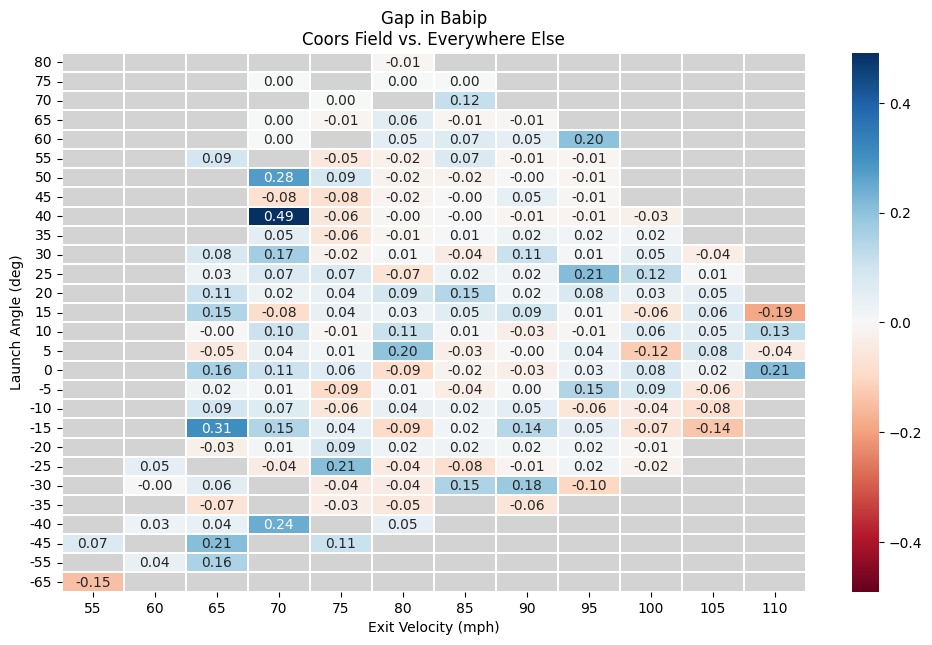

In [137]:
babip_gap_pivot = babip[babip['count_col'] >= min_count].pivot(index='la_bucket', columns='ev_bucket', values='babip_gap')
#gap_pivot[pd.isna(gap_pivot)] = 0.0
babip_gap_pivot = babip_gap_pivot.astype(float)

limit = max(list(babip_gap_pivot.max()) + list(babip_gap_pivot.min()), key=abs)
divnorm = colors.TwoSlopeNorm(vmin = -1 * limit, vcenter = 0, vmax = limit)

fig, ax = plt.subplots(figsize = (12, 7))
ax = sns.heatmap(babip_gap_pivot, cmap = 'RdBu', norm=divnorm, linewidths = 0.01, annot = True, fmt = ".2f")
ax.set_facecolor('lightgray')
ax.invert_yaxis()
ax.set_title('Gap in Babip\nCoors Field vs. Everywhere Else')
ax.set_ylabel('Launch Angle (deg)')
ax.set_xlabel('Exit Velocity (mph)')
plt.show()

In [138]:
step = 5
#min_la = 15
#max_la = 75
#min_ev = 75
#max_ev = 110
min_count = 10

col_df['ev_bucket'] = np.floor(col_df['launch_speed'] / step) * step
col_df['la_bucket'] = np.floor(col_df['launch_angle'] / step) * step
col_bahb_full = col_df.groupby(['ev_bucket', 'la_bucket']).agg(
    avg_bahb_col=('bahb', 'mean'),
    count_col=('bahb', 'count')
).reset_index()
#col_dist = col_dist_full[(col_dist_full.la_bucket >= min_la) & (col_dist_full.la_bucket <= max_la) & (col_dist_full.ev_bucket >= min_ev) & (col_dist_full.ev_bucket <= max_ev)]

in_play_df['ev_bucket'] = np.floor(in_play_df['launch_speed'] / step) * step
in_play_df['la_bucket'] = np.floor(in_play_df['launch_angle'] / step) * step
in_play_bahb_full = in_play_df.groupby(['ev_bucket', 'la_bucket']).agg(
    avg_bahb_tot=('bahb', 'mean'),
    count_tot=('bahb', 'count')
).reset_index()
#in_play_dist = in_play_dist_full[(in_play_dist_full.la_bucket >= min_la) & (in_play_dist_full.la_bucket <= max_la) & (in_play_dist_full.ev_bucket >= min_ev) & (in_play_dist_full.ev_bucket <= max_ev)]

bahb = pd.merge(col_bahb_full, in_play_bahb_full, on=['ev_bucket', 'la_bucket'], how='inner')
bahb['bahb_gap'] = bahb['avg_bahb_col'] - bahb['avg_bahb_tot']
bahb['ev_bucket'] = bahb['ev_bucket'].astype(int)
bahb['la_bucket'] = bahb['la_bucket'].astype(int)

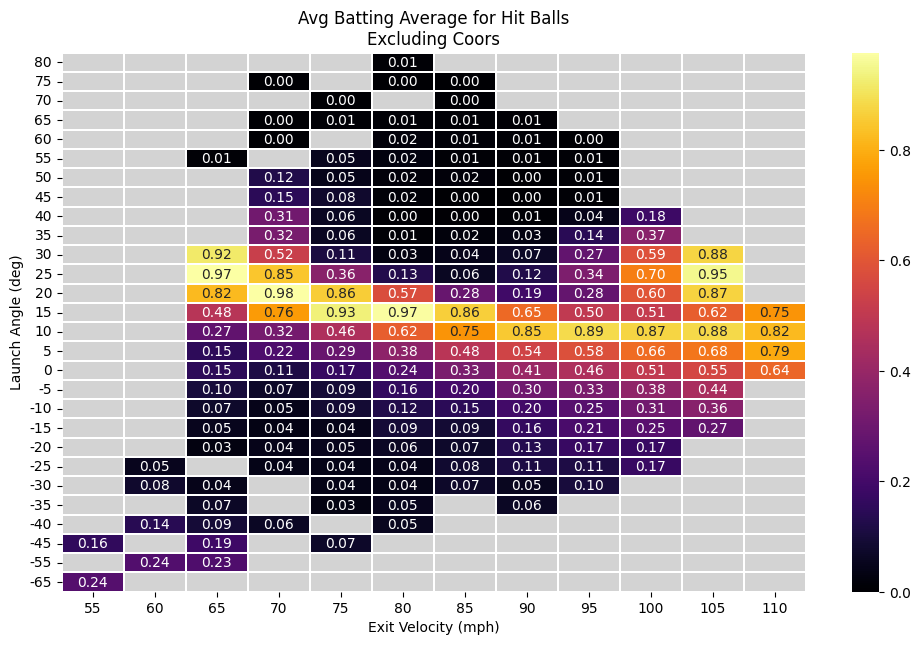

In [ ]:
bahb_pivot = bahb[bahb['count_col'] >= min_count].pivot(index='la_bucket', columns='ev_bucket', values='avg_bahb_tot')
#dist_pivot[pd.isna(dist_pivot)] = 0.0
bahb_pivot = bahb_pivot.astype(float)


#limit = max(list(dist_pivot.max()) + list(dist_pivot.min()), key=abs)
#divnorm = colors.TwoSlopeNorm(vmin = -1 * limit, vcenter = 0, vmax = limit)

fig, ax = plt.subplots(figsize = (12, 7))
ax = sns.heatmap(bahb_pivot, cmap = 'inferno', linewidths = 0.01, annot = True, fmt = ".2f")
ax.set_facecolor('lightgray')
ax.invert_yaxis()
ax.set_title('Avg Batting Average for Hit Balls\nExcluding Coors')
ax.set_ylabel('Launch Angle (deg)')
ax.set_xlabel('Exit Velocity (mph)')
plt.show()

In [143]:
bahb['bahb_gap'].mean()

np.float64(0.032333812724370706)

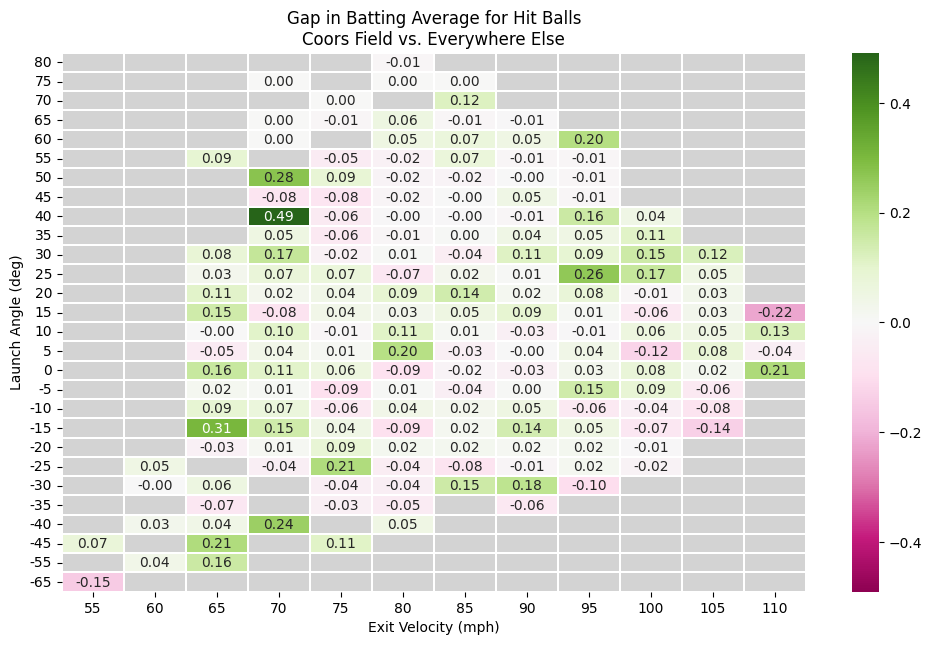

In [142]:
bahb_gap_pivot = bahb[bahb['count_col'] >= min_count].pivot(index='la_bucket', columns='ev_bucket', values='bahb_gap')
#gap_pivot[pd.isna(gap_pivot)] = 0.0
bahb_gap_pivot = bahb_gap_pivot.astype(float)

limit = max(list(bahb_gap_pivot.max()) + list(bahb_gap_pivot.min()), key=abs)
divnorm = colors.TwoSlopeNorm(vmin = -1 * limit, vcenter = 0, vmax = limit)

fig, ax = plt.subplots(figsize = (12, 7))
ax = sns.heatmap(bahb_gap_pivot, cmap = 'PiYG', norm=divnorm, linewidths = 0.01, annot = True, fmt = ".2f")
ax.set_facecolor('lightgray')
ax.invert_yaxis()
ax.set_title('Gap in Batting Average for Hit Balls\nCoors Field vs. Everywhere Else')
ax.set_ylabel('Launch Angle (deg)')
ax.set_xlabel('Exit Velocity (mph)')
plt.show()

In [126]:
step = 5
#min_la = 15
#max_la = 75
#min_ev = 75
#max_ev = 110
min_count = 10

col_df['ev_bucket'] = np.floor(col_df['launch_speed'] / step) * step
col_df['la_bucket'] = np.floor(col_df['launch_angle'] / step) * step
col_iso_full = col_df.groupby(['ev_bucket', 'la_bucket']).agg(
    avg_iso_col=('iso_value', 'mean'),
    count_col=('iso_value', 'count')
).reset_index()
#col_dist = col_dist_full[(col_dist_full.la_bucket >= min_la) & (col_dist_full.la_bucket <= max_la) & (col_dist_full.ev_bucket >= min_ev) & (col_dist_full.ev_bucket <= max_ev)]

in_play_df['ev_bucket'] = np.floor(in_play_df['launch_speed'] / step) * step
in_play_df['la_bucket'] = np.floor(in_play_df['launch_angle'] / step) * step
in_play_iso_full = in_play_df.groupby(['ev_bucket', 'la_bucket']).agg(
    avg_iso_tot=('iso_value', 'mean'),
    count_tot=('iso_value', 'count')
).reset_index()
#in_play_dist = in_play_dist_full[(in_play_dist_full.la_bucket >= min_la) & (in_play_dist_full.la_bucket <= max_la) & (in_play_dist_full.ev_bucket >= min_ev) & (in_play_dist_full.ev_bucket <= max_ev)]

iso = pd.merge(col_iso_full, in_play_iso_full, on=['ev_bucket', 'la_bucket'], how='inner')
iso['iso_gap'] = iso['avg_iso_col'] - iso['avg_iso_tot']
iso['ev_bucket'] = iso['ev_bucket'].astype(int)
iso['la_bucket'] = iso['la_bucket'].astype(int)

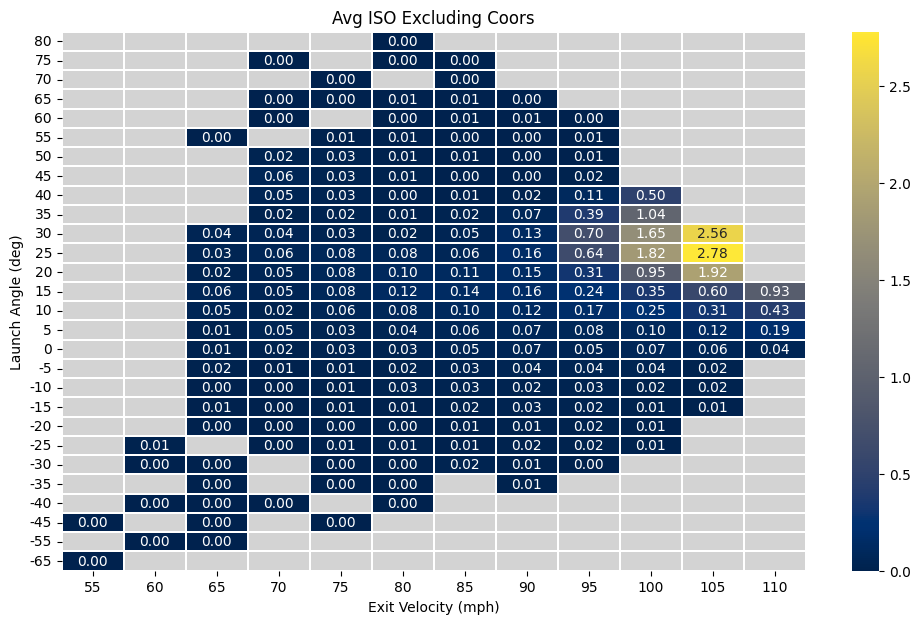

In [127]:
iso_pivot = iso[iso['count_col'] >= min_count].pivot(index='la_bucket', columns='ev_bucket', values='avg_iso_tot')
#dist_pivot[pd.isna(dist_pivot)] = 0.0
iso_pivot = iso_pivot.astype(float)


#limit = max(list(dist_pivot.max()) + list(dist_pivot.min()), key=abs)
#divnorm = colors.TwoSlopeNorm(vmin = -1 * limit, vcenter = 0, vmax = limit)

fig, ax = plt.subplots(figsize = (12, 7))
ax = sns.heatmap(iso_pivot, cmap = 'cividis', linewidths = 0.01, annot = True, fmt = ".2f")
ax.set_facecolor('lightgray')
ax.invert_yaxis()
ax.set_title('Avg ISO Excluding Coors')
ax.set_ylabel('Launch Angle (deg)')
ax.set_xlabel('Exit Velocity (mph)')
plt.show()

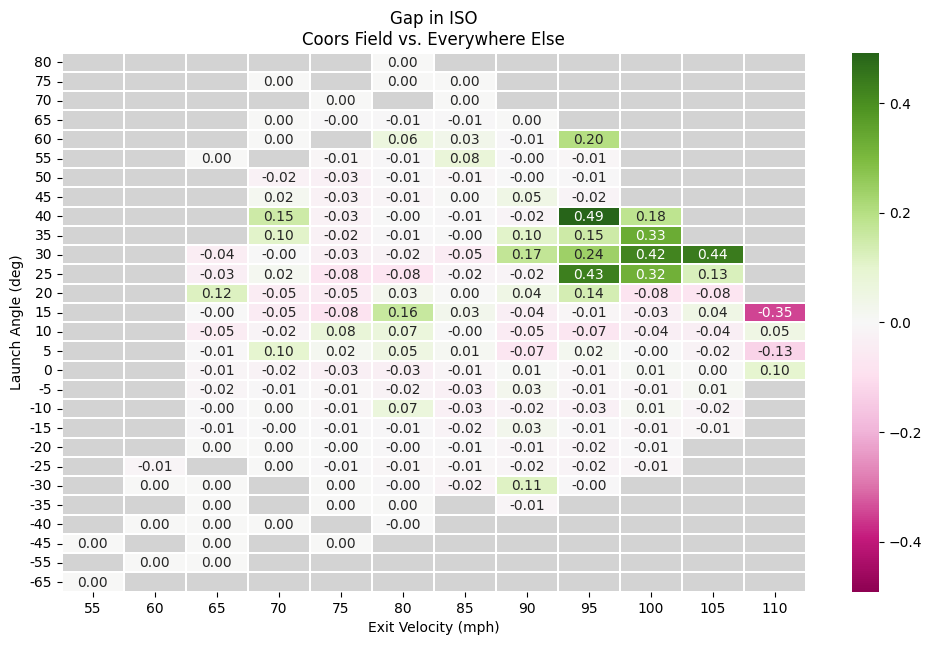

In [144]:
iso_gap_pivot = iso[iso['count_col'] >= min_count].pivot(index='la_bucket', columns='ev_bucket', values='iso_gap')
#gap_pivot[pd.isna(gap_pivot)] = 0.0
iso_gap_pivot = iso_gap_pivot.astype(float)

limit = max(list(iso_gap_pivot.max()) + list(iso_gap_pivot.min()), key=abs)
divnorm = colors.TwoSlopeNorm(vmin = -1 * limit, vcenter = 0, vmax = limit)

fig, ax = plt.subplots(figsize = (12, 7))
ax = sns.heatmap(iso_gap_pivot, cmap = 'PiYG', norm=divnorm, linewidths = 0.01, annot = True, fmt = ".2f")
ax.set_facecolor('lightgray')
ax.invert_yaxis()
ax.set_title('Gap in ISO\nCoors Field vs. Everywhere Else')
ax.set_ylabel('Launch Angle (deg)')
ax.set_xlabel('Exit Velocity (mph)')
plt.show()